## Семинар 7: "Методы оптимизации"

ФИО: Валиахметов Булат Ильдарович

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [278]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:      
            param.grad.zero_()
  
    def step(self, F):
        loss = F()
        loss.backward()        

        
class SGD(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        
        self.learning_rate = learning_rate
    
    def step(self, F):
        super().step(F)
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.learning_rate * param.grad


class Momentum(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                param -= v
                

class NAG(Optimizer):
    def __init__(self, parameters, learning_rate=0.01, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.v = [torch.zeros_like(param) for param in self.parameters]
        self.gamma = gamma
    
    def step(self, F):
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param -= v
        super().step(F)
        with torch.no_grad():
            for v, param in zip(self.v, self.parameters):
                param += v
                
                v.copy_(self.gamma * v + self.learning_rate * param.grad)
                
                param -= v
     
    
class Adagrad(Optimizer):
    def __init__(self, parameters, learning_rate=0.01):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.eps = 1e-9
        self.grad_sums = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for grad_sum, param in zip(self.grad_sums, self.parameters):
                grad_sum += param.grad ** 2
                param -= self.learning_rate / torch.sqrt(grad_sum + self.eps) * param.grad
    
    
class RMSProp(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.9):
        super().__init__(parameters)
        self.learning_rate = learning_rate
        self.G = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-8
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, param in zip(self.G, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                
                param -= self.learning_rate / torch.sqrt(g + self.eps) * param.grad
                

class Adadelta(Optimizer):
    def __init__(self, parameters, learning_rate=0.1, gamma=0.95):
        super().__init__(parameters)
        self.Eg = [torch.zeros_like(param) for param in self.parameters]
        self.Edp = [torch.zeros_like(param) for param in self.parameters]
        self.eps = 1e-3
        self.gamma = gamma
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            for g, dp, param in zip(self.Eg, self.Edp, self.parameters):
                g.copy_(self.gamma * g + (1 - self.gamma) * param.grad**2)
                new_dp = torch.sqrt((dp + self.eps) / (g + self.eps)) * param.grad
                param -= new_dp
                dp.copy_(self.gamma * dp + (1 - self.gamma) * new_dp ** 2)


class Adam(Optimizer):
    def __init__(self, parameters, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(parameters)
        self.M = [torch.zeros_like(param) for param in self.parameters]
        self.V = [torch.zeros_like(param) for param in self.parameters]
        self.eps = eps
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate = learning_rate
        self.time_step = 0
    
    def step(self, F):
        super().step(F)
        with torch.no_grad():
            self.time_step += 1
            for m, v, param in zip(self.M, self.V, self.parameters):
                m.copy_(self.beta1 * m + (1 - self.beta1) * param.grad)
                v.copy_(self.beta2 * v + (1 - self.beta2) * param.grad ** 2)
                
                m_true = m / (1 - self.beta1 ** self.time_step)
                v_true = v / (1 - self.beta2 ** self.time_step)
                #print(m_true, v_true)
                param -= self.learning_rate * m_true / (torch.sqrt(v_true) + self.eps)

In [279]:
def F0(x):
    x, y = x[:, 0], x[:, 1]
    return torch.sin(x) * x**2 * y + torch.cos(y**2) * y**2

def test_method(F, optim, learning_rate, x_0, steps=20, print_pts=False):
    if print_pts:
        print(optim.__name__)

    x = torch.tensor(x_0, requires_grad=True)
    optim = optim([x], learning_rate=learning_rate)

    points = []

    for i in range(steps):
        p_z = F(x).item()
        p_x, p_y = x.detach().numpy().flatten()        
        if print_pts:
            print(i, p_z, p_x, p_y)
        points.append((p_x, p_y, p_z))

        optim.step(lambda: F(x))
        optim.zero_grad()

    return points

In [290]:
def plot_optims(optim_path, names):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(121, projection='3d')
    colors = ["red", "blue", "yellow", "pink", "green", "gray", "black"]

    # Plot a basic wireframe.
    #ax.plot_wireframe(space, space, Z)
    for color, path in zip(colors, optim_path):
        points = np.array(path)
        points += np.random.rand(3) * 0.04
        plt.plot(points[:, 0], points[:, 1], points[:, 2], color=color, linewidth=3)

    plt.subplot(122)
    for color, path, name in zip(colors, optim_path, names):
        points = np.array(path)        
        plt.plot(points[:, 0], points[:, 1], color=color, linewidth=3, label=name)
    plt.legend(fontsize=10)
    plt.show()

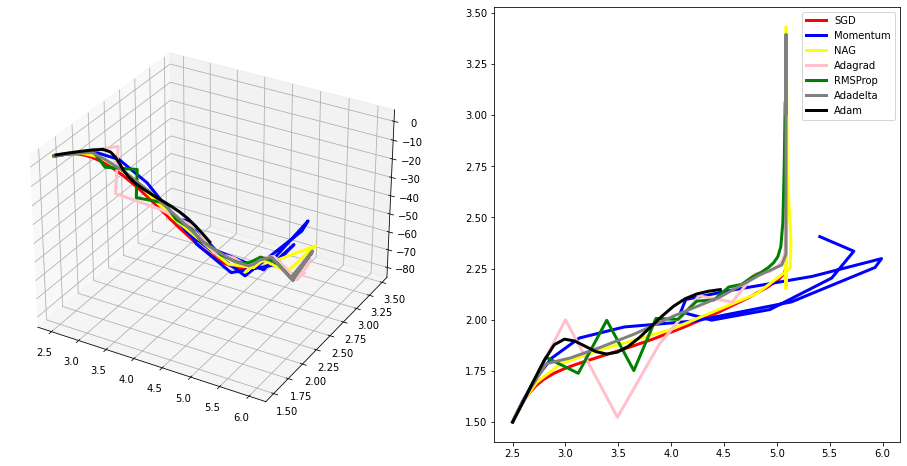

In [291]:
def test_func_by_all(func, x_0, steps=20, print_pts=False):
    optimizers = [SGD, Momentum, NAG, Adagrad, RMSProp, Adadelta, Adam]
    l_rates = [0.01, 0.01, 0.01, 0.5, 0.1, None, 0.1]
    optim_path = []
    names = [optim.__name__ for optim in optimizers]
    for opt, l_r in zip(optimizers, l_rates):
        optim_path.append(test_method(func, opt, l_r, x_0, steps, print_pts))
    plot_optims(optim_path, names)
    

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(F0, x_0)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

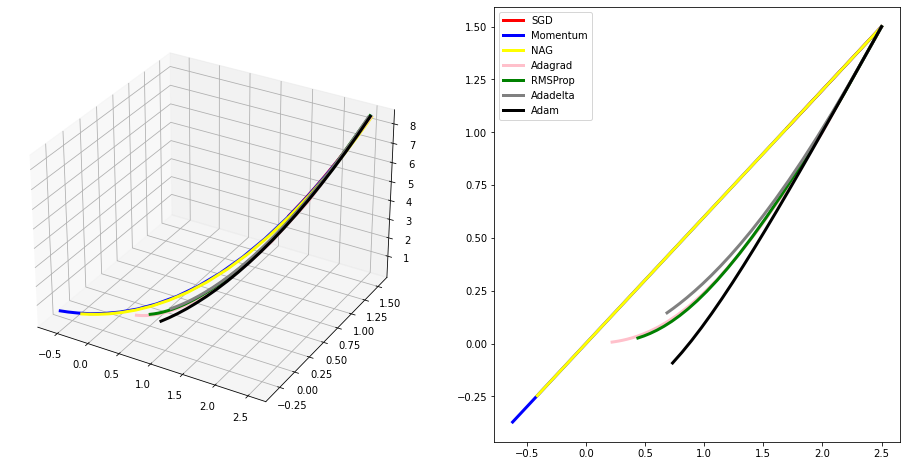

In [293]:
f = lambda X: X[:, 0]**2+X[:, 1]**2
# df = lambda X: np.array([2*X[0], 2*X[1]])

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=20)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

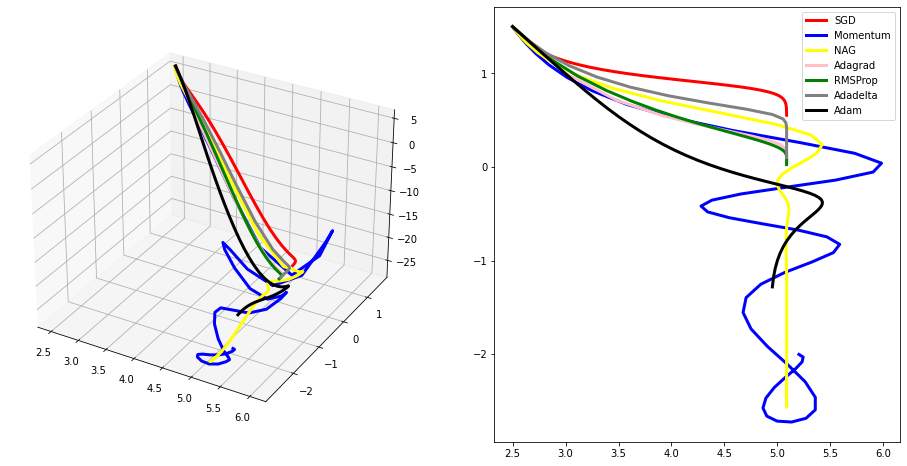

In [296]:
f = lambda X: X[:, 0]**2 * torch.sin(X[:, 0]) + X[:, 1]**2 * torch.sin(X[:, 1])

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=50)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

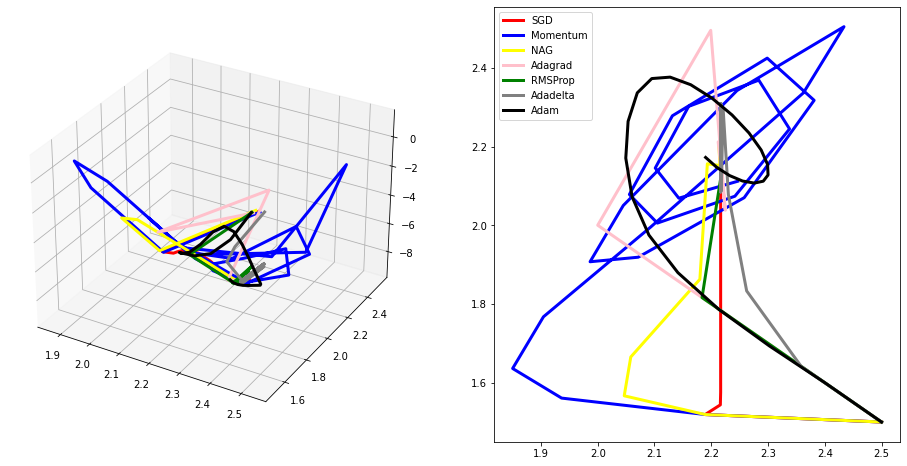

In [300]:
f = lambda X: X[:, 0]**2 * torch.sin(X[:, 0]**2) + X[:, 1]**2 * torch.sin(X[:, 1]**2)

x_0 = np.array([2.5, 1.5]).reshape(1, -1)
test_func_by_all(f, x_0, steps=25)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [ ]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

In [ ]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: